In [1]:
import numpy as np
import pyopencl as cl
from PIL import Image
from IPython.display import display, clear_output

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.autograd import Variable
import torchvision.transforms as T

In [4]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (20.0, 8.0)
plt.rcParams['image.interpolation'] = 'bilinear'
plt.rcParams['image.cmap'] = 'hot'

In [5]:
from util import *
from clutil import *
from compute import *
from generate import *

%load_ext autoreload
%autoreload 2

In [6]:
ctx = cl.create_some_context()

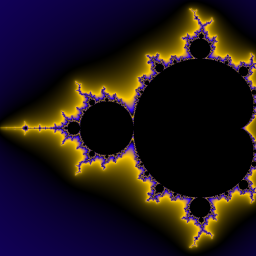

In [7]:
scene = Scene(ctx, (1024, 1024), scale=4)
scene.compute((-0.8, 0), (2.4, 0), max_depth=1024)
display_image(scene.colorize([[0,0,0,1], [1,0.8,0,1], [0.2,0,1,1]], period=20))

In [10]:
discover([4, 2, 1], jump=4, ctx=ctx)#, draw=scene)

array([[ 0.44785714, -0.20071429,  0.0375    ],
       [ 0.38928571, -0.24571429,  0.0375    ],
       [-0.65642857,  0.34857143,  0.0375    ],
       [-0.23857143,  0.80642857,  0.0375    ],
       [-1.33214286,  0.06928571,  0.0375    ],
       [-1.26214286, -0.125     ,  0.0375    ],
       [-0.71714286, -0.35714286,  0.0375    ],
       [-0.49      , -0.61428571,  0.0375    ]])

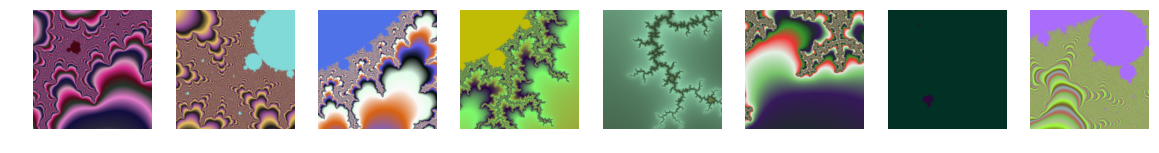

In [12]:
plot_images(generate(scene, [4, 2, 1], 4, ctx=ctx)[0])

In [13]:
torch.cuda.is_available()

True

In [14]:
class UNet(nn.Module):
    def __init__(self, down, middle, up, ksize=3):
        super().__init__()
        
        self.kernel_size = ksize
        pad = (ksize - 1)//2;
        
        levels = []
        for level in down:
            layers = []
            for conv_in, conv_out in zip(level[:-1], level[1:]):
                layers.extend([
                    nn.Conv2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                    nn.ReLU(),
                ])
            layers.append(nn.MaxPool2d(2, stride=2))
            levels.append(nn.ModuleList(layers))
        self.down = nn.ModuleList(levels)
        
        layers = []
        for conv_in, conv_out in zip(middle[:-1], middle[1:]):
            layers.extend([
                nn.Conv2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                nn.ReLU(),
            ])
        self.middle = nn.ModuleList(layers)
        last_size = middle[-1]
        
        levels = []
        for level in up:
            layers = []
            layers.append(nn.ConvTranspose2d(last_size, level[0], kernel_size=2, stride=2))
            for conv_in, conv_out in zip(level[:-1], level[1:]):
                layers.extend([
                    nn.ConvTranspose2d(conv_in, conv_out, kernel_size=ksize, padding=pad),
                    nn.ReLU(),
                ])
            layers.pop()
            levels.append(nn.ModuleList(layers))
            last_size = level[-1]
        self.up = nn.ModuleList(levels)
        
        layers = []
        for down_level, up_level in zip(reversed(down), up):
            layers.append(nn.Conv2d(down_level[-1], up_level[0], kernel_size=1, padding=0))
        self.short = nn.ModuleList(layers)
    
    def forward(self, x):
        indices = []
        shortcuts = []
        for j, d in enumerate(self.down):
            try:
                s = self.short[len(self.down) - j - 1]
            except IndexError:
                s = None
            for i, l in enumerate(d):
                x = l(x)
                if i == len(d) - 2 and s is not None:
                    shortcuts.append(s(x))
            
        for i, l in enumerate(self.middle):
            x = l(x)
        
        for j, u in enumerate(self.up):
            try:
                z = shortcuts[-j-1]
            except IndexError:
                z = None
            for i, l in enumerate(u):
                if i == 1 and z is not None:
                    x = x + z
                x = l(x)
        return x

In [15]:
def train_adversarial(model, loss_fn, optimizer, xdata, ydata, test=False):
    if test:
        model.eval()
    else:
        model.train()
    
    x_var = Variable(Tensor(xdata).cuda(), volatile=test)
    y_var = Variable(Tensor(ydata).cuda(), volatile=test)
    
    if not test:
        optimizer.zero_grad()

    y_pred = model(x_var)

    loss = loss_fn(y_pred, y_var)

    if not test:
        loss.backward()#retain_graph=True)

    x_var = y_pred

    if not test:
        optimizer.step()
        
    return loss.data[0]

In [16]:
def apply_model(model, x):
    model.eval()
    x_var = Variable(Tensor(x).cuda(), volatile=True)
    y_pred = model(x_var)
    return y_pred.data.cpu().numpy()

In [17]:
def test_images(scene, model):
    ximage, yimage = [img[:,:,:,:3] for img in generate(scene, [4, 1, 1], 4, layers=(0,1))]
    x = ximage.transpose(0,3,1,2)
    y = apply_model(model, x)
    result = y.transpose(0,2,3,1)
    return (ximage, yimage, result)

In [18]:
model = UNet(
    down=(
        (3, 32, 32),
        (32, 64, 64),
    ),
    middle=(64, 128, 128),
    up=(
        (64, 64, 64),
        (32, 32, 32),
        (16, 16, 16),
        (8, 8, 8, 3),
    ),
).cuda()

In [ ]:
loss_fn = nn.MSELoss().cuda()
optimizer = optim.Adam(model.parameters(), lr=2e-4)

In [125]:
train_scene = Scene(ctx, (512, 512), scale=(8,2))
step = 0
loss = 0.0
losses = []
steps = []

835000: 0.003472015151171945


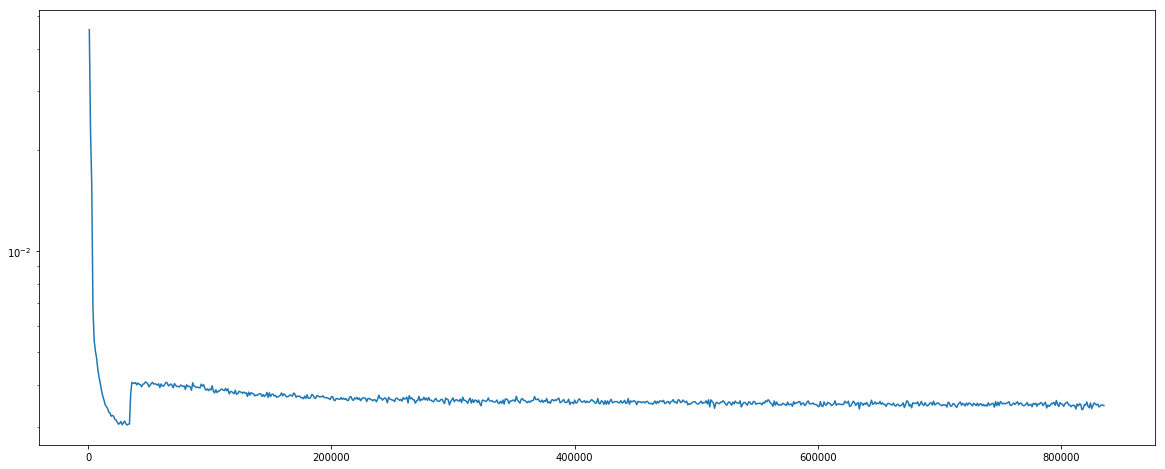

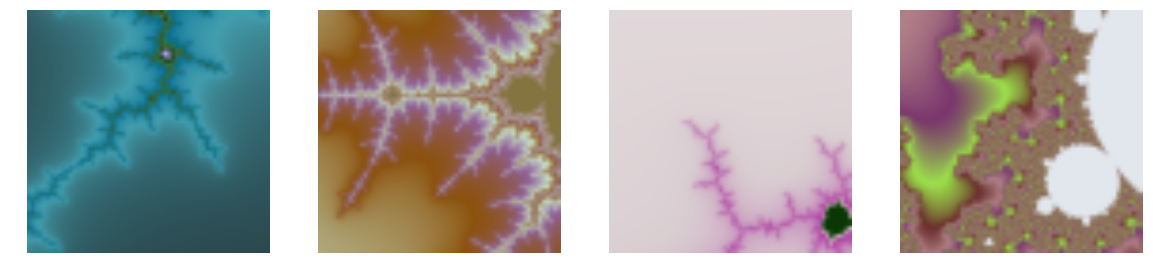

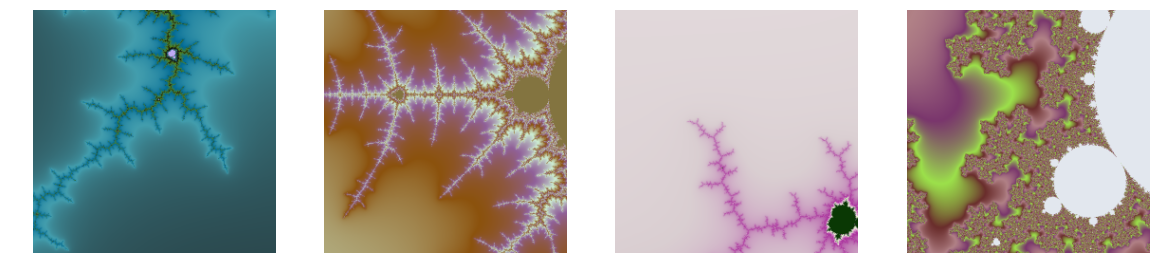

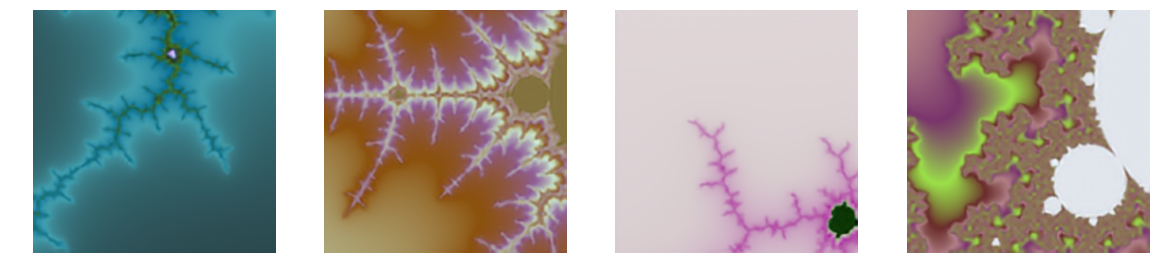

In [218]:
print_every = 1000
stop_on_signal()
while not signal_done:
    data = generate(train_scene, [2, 2, 2], 4, layers=(0,1))
    xdata, ydata = [img.transpose(0,3,1,2)[:,:3,:,:] for img in data]
    loss += train_model(model, loss_fn, optimizer, xdata, ydata)
    if (step+1) % print_every == 0:
        clear_output()
        loss /= print_every
        print("%s: %s" % (step+1, loss))
        steps.append(step+1)
        losses.append(loss)
        plt.plot(steps, losses)
        plt.yscale('log')
        plt.show()
        for imgs in test_images(train_scene, model):
            plot_images(imgs)
        loss = 0.0    
    step += 1

In [227]:
torch.save(model.state_dict(), "models/upscale_0.1.1.data")

In [19]:
model.load_state_dict(torch.load("models/upscale_0.1.1.data"))

In [30]:
pic = Image.open("samples/kitten.jpg")
w, h = pic.size
dw = (w-h)/2
pic = pic.crop((dw, 0, h+dw, h)).resize((16,16), Image.ANTIALIAS)
display(pic)

(16, 16, 3)


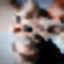

In [31]:
pix = (np.array(pic, dtype=np.float32)/255)
print(pix.shape)
x = pix.reshape(1,*pix.shape).transpose(0,3,1,2)
y = apply_model(model, x)
result = y.transpose(0,2,3,1)
display_image(result[0])

(64, 64, 3)


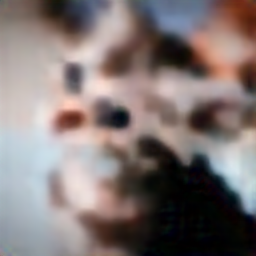

In [32]:
pix2 = result[0]
print(pix2.shape)
x = pix2.reshape(1,*pix2.shape).transpose(0,3,1,2)
y = apply_model(model, x)
result2 = y.transpose(0,2,3,1)
display_image(result2[0])